# -- The first replication --

## 1. Data wrangling

The first step is to load the data and organize them into a required format. Since the paper used the log of the observation, we can generate a new column that contains these log values.

In [21]:
import pandas as pd
import numpy as np

# Read data
merged_autos = pd.read_csv('data/merged_autos.csv')

# Set a new copy of merged_autos dataframe
autos = merged_autos.copy()

# Convert the datetime
autos['Period'] = pd.to_datetime(autos['Period'])

# Log the sales
autos['y'] = autos["sales"].apply(np.log)

# Set 'Period' as new index
autos.set_index('Period', inplace = True)
autos

,sales,suvs,insurance,y
Period,,,,
2004-01-01,61287,0.00,0.00,11.023323
2004-02-01,65381,-0.12,-0.01,11.087987
2004-03-01,78843,-0.05,-0.09,11.275214
2004-04-01,73422,-0.12,-0.08,11.203979
2004-05-01,77662,-0.07,-0.07,11.260121
...,...,...,...,...
2011-03-01,75982,-0.03,-0.19,11.238252
2011-04-01,70364,-0.08,-0.20,11.161437
2011-05-01,70070,-0.16,-0.22,11.157250


Now I plot the figure corresponding to the actual value curve in the paper to check whether there is a big deviation from it. It can be seen from the figure that the results are basically the same, so the experiment can continue.

In [22]:
# Extract data after periods k
truth = autos['y'][17:]
truth

Period
2005-06-01    11.356669
2005-07-01    11.383602
2005-08-01    11.307008
2005-09-01    11.149931
2005-10-01    11.062568
                ...    
2011-03-01    11.238252
2011-04-01    11.161437
2011-05-01    11.157250
2011-06-01    11.166865
2011-07-01    11.154964
Name: y, Length: 74, dtype: float64

Text(0, 0.5, 'log(mvp)')

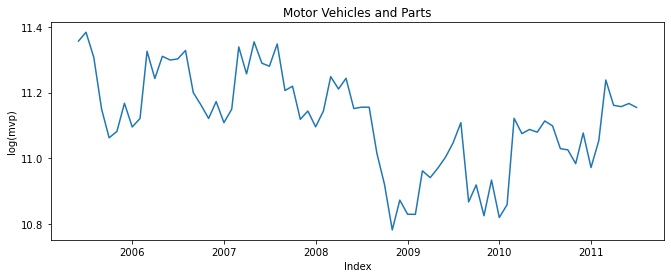

In [23]:
import matplotlib.pyplot as plt

# Plot the figure of actual values
plt.figure(figsize = (11,4))
plt.plot(truth)
plt.yticks([10.8, 11.0, 11.2, 11.4])
plt.title("Motor Vehicles and Parts")
plt.xlabel("Index")
plt.ylabel("log(mvp)")

## 2. The baseline model without Google Trends data

The key in this step is to obtain the proper training set and fit the AR-1 model to get the predicted values.

When obtaining the initial training set, a noteworthy point is that each group has two eigenvalues (yt-1 and yt-12).

In terms of the model, I call the linear_model module in sklearn to create the linear regression model. Due to the characteristics of rolling window forecast, I choose to predict the value of each month in a loop and continuously add new values in the dataframe to the training set. Therefore, the training set is constantly expanding during the entire prediction process.

In [24]:
# Get the initial training set of yt-1 and yt-12
X1 = list()
for i in range(12,17):
    X1 += [[autos['y'][i-1],autos['y'][i-12]]]
X1

[[11.192720200812888, 11.023323027655763],
 [11.035921389679748, 11.08798697535854],
 [11.113730657375424, 11.275213812293087],
 [11.299150392097582, 11.203978897213723],
 [11.261922416776939, 11.260121356237592]]

In [25]:
# Get the initial training set of yt
Y1 = list()
for i in range(12,17):
    Y1 += [autos['y'][i]]
Y1

[11.035921389679748,
 11.113730657375424,
 11.299150392097582,
 11.261922416776939,
 11.270548124540719]

In [26]:
# Call the linear_model module in sklearn for linear regression
from sklearn import linear_model

# Create the prediction list
predictions_base = list()

# Create the linear regression model, i.e. the AR-1 model in this case
model_base = linear_model.LinearRegression()

for t in range(17,len(autos)): 
    # Model fit
    model_base.fit(X1, Y1)
    # Get the predicted value
    yhat_base = np.dot(model_base.coef_,[autos['y'][t-1],autos['y'][t-12]]) + model_base.intercept_
    # Add the predicted value to the prediction list
    predictions_base.append(yhat_base)
    # Add new values in the dataframe to the training set
    X1.append([autos['y'][t-1],autos['y'][t-12]])
    Y1.append(autos['y'][t])

## 3. The model using the Google Trends data

The prediction with Google Trends data is basically the same as before. The main difference is that the number of eigenvalues in each group in the training set is now increased to 4.

In [27]:
# Get the initial training set of yt-1 and yt-12
X2 = list()
for i in range(12,17):
    X2 += [[autos['y'][i-1],autos['y'][i-12],autos['suvs'][i],autos['insurance'][i]]]
X2

[[11.192720200812888, 11.023323027655763, -0.11, 0.0],
 [11.035921389679748, 11.08798697535854, -0.1, -0.17],
 [11.113730657375424, 11.275213812293087, -0.09, -0.1],
 [11.299150392097582, 11.203978897213723, -0.14, -0.13],
 [11.261922416776939, 11.260121356237592, -0.15, -0.14]]

In [28]:
# Get the initial training set of yt
Y2 = list()
for i in range(12,17):
    Y2 += [autos['y'][i]]
Y2

[11.035921389679748,
 11.113730657375424,
 11.299150392097582,
 11.261922416776939,
 11.270548124540719]

In [29]:
# Create the prediction list
predictions_trends = list()

# Create the linear regression model, i.e. the AR-1 model with Google Trends data in this case
model_trends = linear_model.LinearRegression()

for t in range(17,len(autos)):  
    # Model fit
    model_trends.fit(X2, Y2)
    # Get the predicted value
    yhat_trends = np.dot(model_trends.coef_,[autos['y'][t-1],autos['y'][t-12],autos['suvs'][t],autos['insurance'][t]]) + model_trends.intercept_
    # Add the predicted value to the prediction list
    predictions_trends.append(yhat_trends)
    # Add new values in the dataframe to the training set
    X2.append([autos['y'][t-1],autos['y'][t-12],autos['suvs'][t],autos['insurance'][t]])
    Y2.append(autos['y'][t])

## 4. Plot the figure

Now I have got the predicted values under the two methods, so I can calculate the corresponding MAE and plot the figure. The figure I got reproduced the results in the original text well.

In addition, I also found that the author made a descriptive mistake related to the MAE during the recession, that is, the MAE without and with Google Trends data should be 9.29% and 7.29% separately. But the improvement values of MAE we got are both 21.5%. So our forecast results should be consistent.

In [30]:
from sklearn.metrics import mean_absolute_error

# Calculate the MAE
MAE_base = mean_absolute_error(truth, predictions_base)
MAE_trends = mean_absolute_error(truth, predictions_trends)

# Print the results
print("MAE_base = %.2f%%" %(MAE_base * 100))
print("MAE_trends = %.2f%%" %(MAE_trends * 100))

MAE_base = 6.34%
MAE_trends = 5.67%


In [31]:
# Calculate the MAE improvement
MAE_improvement_overall = (MAE_base - MAE_trends) / MAE_base

# Print the results
print("MAE_improvement_overall = %.1f%%" %(MAE_improvement_overall * 100))

MAE_improvement_overall = 10.7%


In [32]:
# Calculate the MAE during the recession (December 2007 through June 2009)
MAE_base_rec = mean_absolute_error(truth[30:48], predictions_base[30:48])
MAE_trends_rec = mean_absolute_error(truth[30:48], predictions_trends[30:48])

# Print the results
print("MAE_base_rec = %.2f%%" %(MAE_base_rec * 100))
print("MAE_trends_rec = %.2f%%" %(MAE_trends_rec * 100))

MAE_base_rec = 9.29%
MAE_trends_rec = 7.29%


In [33]:
# Calculate the MAE improvement during the recession (December 2007 through June 2009)
MAE_improvement_recession = (MAE_base_rec - MAE_trends_rec) / MAE_base_rec

# Print the results
print("MAE_improvement_recession = %.1f%%" %(MAE_improvement_recession * 100))

MAE_improvement_recession = 21.5%


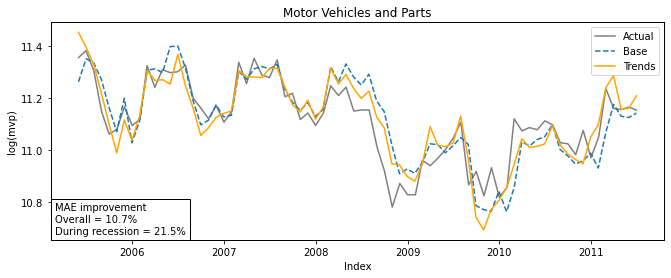

In [34]:
# Plot the figure
fig, ax1 = plt.subplots(figsize = (11,4))

# Plot "truth"
ax1.set_xlabel("Index")
ax1.set_ylabel("log(mvp)")
l1, = ax1.plot(truth, color = 'gray')
ax1.tick_params(axis = 'x')
plt.yticks([10.8, 11.0, 11.2, 11.4])

# Plot "predictions_base"
ax2 = ax1.twiny()
l2, = ax2.plot(predictions_base, linestyle = '--')
ax2.tick_params(axis = 'x')
plt.xticks([])

# Plot "predictions_trends"
ax3 = ax1.twiny()
l3, = ax3.plot(predictions_trends, color = 'orange')
ax3.tick_params(axis = 'x')
plt.xticks([])

# Add legend and annotation
plt.legend([l1, l2, l3], ['Actual', 'Base', 'Trends'], loc = 'upper right') 
plt.text(-3.1, 10.68, "MAE improvement\nOverall = 10.7%\nDuring recession = 21.5%", bbox = dict(ec = 'black', fc = 'white'))

# Set the title and show the figure
plt.title("Motor Vehicles and Parts")
plt.show()

# -- The second replication --

## 1. Data wrangling

The first step is to load the data and organize them into a required format. Since the paper used the log of the seasonally adjusted claims data, we can generate a new column that contains these log values.

In [4]:
import pandas as pd
import numpy as np

# Read data
merged_iclaims = pd.read_csv('data/merged_iclaims.csv')

# Set a new copy of merged_iclaims dataframe
claims = merged_iclaims.copy()

# Log the seasonally adjusted claims data
claims['log'] = claims["claims.sa"].apply(np.log)

# Set 'Index' as new index
claims.set_index('Index', inplace = True)

claims.head()

,claims.sa,claims.nsa,Jobs,Welfare...Unemployment,log
Index,,,,,
2004/01/10,354000,677897,6.066862,-7.574152,12.777052
2004/01/17,362000,490763,-3.558773,-25.237886,12.799399
2004/01/24,353000,382262,-6.184409,-17.401619,12.774223
2004/01/31,376000,406298,-7.935044,-18.815352,12.837344
2004/02/07,380000,433234,-13.310680,-24.104085,12.847927


Here plot a part of the log values to check the data. The curve obtained is the same as that in the paper.

Text(0, 0.5, 'log(iclaims)')

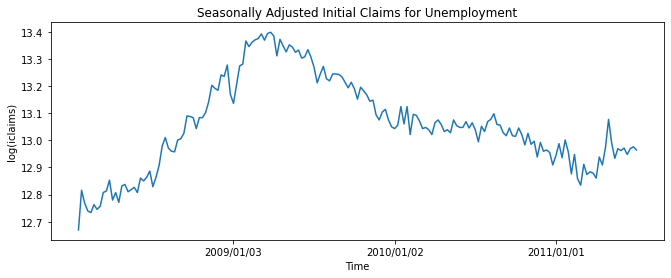

In [5]:
import matplotlib.pyplot as plt

# Plot the figure of the log values
plt.figure(figsize = (11,4))
plt.plot(claims['2008/01/19':]['log'])
plt.title('Seasonally Adjusted Initial Claims for Unemployment')
plt.xticks(['2009/01/03', '2010/01/02', '2011/01/01'])
plt.xlabel("Time")
plt.ylabel("log(iclaims)")

## 2. The baseline model without Google Trends data

Then I use the linear regression model to get the predicted values. In this case the authors only used yt-1 to predict yt, which means that each group only has one eigenvalue(yt-1).

I make the prediction from the beginning of the dataset. To add these predicted values to the dataframe and make the dates of the data correspond, the length of the prediction list should be the same as the length of columns in the dataframe. So I let the first two values in the prediction list be equal to zero, which cannot be predicted since there's no earlier data before them.

Same as the first replication, the trainging set is constantly expanding during the prediction process. So I predict the value of each month in a loop and continuously add new values in the dataframe to the training set.

In [6]:
# Get the initial training set of yt-1 and yt
X1 = [claims['log'][0]]
Y1 = [claims['log'][1]]

# Create the prediction list
predictions_base = list()
predictions_base = [0, 0]

In [7]:
# Call the linear_model module in sklearn for linear regression
from sklearn import linear_model

# Create the linear regression model
model_base = linear_model.LinearRegression()

for t in range(2,len(claims)):
    
    # Model fit
    model_base.fit(np.array(X1).reshape(-1, 1), np.array(Y1).reshape(-1, 1))
    
    # Get the predicted value
    past = np.array(claims['log'][t-1]).reshape(-1, 1)
    yhat_base = model_base.predict(past)[0]
    
    # Add the predicted value to the prediction list
    predictions_base.append(yhat_base)
    
    # Add new values in the dataframe to the training set
    X1.append(claims['log'][t-1])
    Y1.append(claims['log'][t])

In [8]:
# Add predicted values to the dataframe
claims['base'] = predictions_base
claims.head()

,claims.sa,claims.nsa,Jobs,Welfare...Unemployment,log,base
Index,,,,,,
2004/01/10,354000,677897,6.066862,-7.574152,12.777052,0
2004/01/17,362000,490763,-3.558773,-25.237886,12.799399,0
2004/01/24,353000,382262,-6.184409,-17.401619,12.774223,[12.799399490807907]
2004/01/31,376000,406298,-7.935044,-18.815352,12.837344,[12.802586440732076]
2004/02/07,380000,433234,-13.310680,-24.104085,12.847927,[12.697185462916515]


## 3. The model using the Google Trends data

In the model using the Google Trends data, the only change is to add two new eigenvalues to the training set.

In [9]:
# Get the initial training set of yt-1 and yt
X2 = [[claims['log'][0], claims['Jobs'][1], claims['Welfare...Unemployment'][1]]]
Y2 = [claims['log'][1]]

# Create the prediction list
predictions_trends = list()
predictions_trends = [0, 0]

In [10]:
# Create the linear regression model
model_trends = linear_model.LinearRegression()

for t in range(2,len(claims)):
    
    # Model fit
    model_trends.fit(X2, Y2)
    
    # Get the predicted value
    past = np.array([claims['log'][t-1], claims['Jobs'][t], claims['Welfare...Unemployment'][t]]).reshape(-3, 3)
    yhat_trends = model_trends.predict(past)[0]
    
    # Add the predicted value to the prediction list
    predictions_trends.append(yhat_trends)
    
    # Add new values in the dataframe to the training set
    X2.append([claims['log'][t-1], claims['Jobs'][t], claims['Welfare...Unemployment'][t]])
    Y2.append(claims['log'][t])

In [11]:
# Add predicted values to the dataframe
claims['trends'] = predictions_trends
claims.head()

,claims.sa,claims.nsa,Jobs,Welfare...Unemployment,log,base,trends
Index,,,,,,,
2004/01/10,354000,677897,6.066862,-7.574152,12.777052,0,0.000000
2004/01/17,362000,490763,-3.558773,-25.237886,12.799399,0,0.000000
2004/01/24,353000,382262,-6.184409,-17.401619,12.774223,[12.799399490807907],12.799399
2004/01/31,376000,406298,-7.935044,-18.815352,12.837344,[12.802586440732076],12.776613
2004/02/07,380000,433234,-13.310680,-24.104085,12.847927,[12.697185462916515],12.970880


## 4. Calculate MAE

Now all the data are ready, the final work is to select the data corresponding to the four time periods in the paper and calculate their MSE.

In [12]:
# Select the first time period
period_1 = claims['2009/03/01':'2009/05/01']['log']
base_1 = claims['2009/03/01':'2009/05/01']['base']
trends_1 = claims['2009/03/01':'2009/05/01']['trends']

In [13]:
from sklearn.metrics import mean_absolute_error

# Calculate the MAE
MAE_base_1 = mean_absolute_error(period_1, base_1)
MAE_trends_1 = mean_absolute_error(period_1, trends_1)

# Calculate the 1 - ratio
ratio_1 = 1 - MAE_trends_1 / MAE_base_1

# Convert data format
MAE_base_1 = round(MAE_base_1, 4)
MAE_trends_1 = round(MAE_trends_1, 5)
ratio_1 = round(ratio_1, 4)
ratio_1 = format(ratio_1, '.2%')

# Print the results
print("MAE_base =", MAE_base_1)
print("MAE_trends =", MAE_trends_1)
print("1 - ratio =", ratio_1)

MAE_base = 0.0307
MAE_trends = 0.02399
1 - ratio = 21.86%


In [14]:
# Select the second time period
period_2 = claims['2009/12/01':'2010/02/01']['log']
base_2 = claims['2009/12/01':'2010/02/01']['base']
trends_2 = claims['2009/12/01':'2010/02/01']['trends']

In [15]:
# Calculate the MAE
MAE_base_2 = mean_absolute_error(period_2, base_2)
MAE_trends_2 = mean_absolute_error(period_2, trends_2)

# Calculate the 1 - ratio
ratio_2 = 1 - MAE_trends_2 / MAE_base_2

# Convert data format
MAE_base_2 = round(MAE_base_2, 4)
MAE_trends_2 = round(MAE_trends_2, 5)
ratio_2 = round(ratio_2, 4)
ratio_2 = format(ratio_2, '.2%')

# Print the results
print("MAE_base =", MAE_base_2)
print("MAE_trends =", MAE_trends_2)
print("1 - ratio =", ratio_2)

MAE_base = 0.0357
MAE_trends = 0.03127
1 - ratio = 12.36%


In [16]:
# Select the third time period
period_3 = claims['2010/07/15':'2010/10/01']['log']
base_3 = claims['2010/07/15':'2010/10/01']['base']
trends_3 = claims['2010/07/15':'2010/10/01']['trends']

In [17]:
# Calculate the MAE
MAE_base_3 = mean_absolute_error(period_3, base_3)
MAE_trends_3 = mean_absolute_error(period_3, trends_3)

# Calculate the 1 - ratio
ratio_3 = 1 - MAE_trends_3 / MAE_base_3

# Convert data format
MAE_base_3 = round(MAE_base_3, 4)
MAE_trends_3 = round(MAE_trends_3, 5)
ratio_3 = round(ratio_3, 4)
ratio_3 = format(ratio_3, '.2%')

# Print the results
print("MAE_base =", MAE_base_3)
print("MAE_trends =", MAE_trends_3)
print("1 - ratio =", ratio_3)

MAE_base = 0.0253
MAE_trends = 0.02446
1 - ratio = 3.22%


In [18]:
# Select the forth time period
period_4 = claims['2011/01/01':'2011/05/01']['log']
base_4 = claims['2011/01/01':'2011/05/01']['base']
trends_4 = claims['2011/01/01':'2011/05/01']['trends']

In [19]:
# Calculate the MAE
MAE_base_4 = mean_absolute_error(period_4, base_4)
MAE_trends_4 = mean_absolute_error(period_4, trends_4)

# Calculate the 1 - ratio
ratio_4 = 1 - MAE_trends_4 / MAE_base_4

# Convert data format
MAE_base_4 = round(MAE_base_4, 4)
MAE_trends_4 = round(MAE_trends_4, 5)
ratio_4 = round(ratio_4, 4)
ratio_4 = format(ratio_4, '.2%')

# Print the results
print("MAE_base =", MAE_base_4)
print("MAE_trends =", MAE_trends_4)
print("1 - ratio =", ratio_4)

MAE_base = 0.0514
MAE_trends = 0.05101
1 - ratio = 0.66%


In [20]:
import prettytable as pt

# Create the table
tb = pt.PrettyTable()

# Set the title
tb.title = 'Behavior of MAE around Turning Points'

# Set column names
tb.field_names = ['Start', 'End', 'MAE base', 'MAE trends', '1-ratio']

# Add data
tb.add_row(['2009-03-01', '2009-05-01', MAE_base_1, MAE_trends_1, ratio_1])
tb.add_row(['2009-12-01', '2010-02-01', MAE_base_2, MAE_trends_2, ratio_2])
tb.add_row(['2010-07-15', '2010-10-01', MAE_base_3, MAE_trends_3, ratio_3])
tb.add_row(['2011-01-01', '2011-05-01', MAE_base_4, MAE_trends_4, ratio_4])

# Print the table
print(tb)

+-----------------------------------------------------------+
|           Behavior of MAE around Turning Points           |
+------------+------------+----------+------------+---------+
|   Start    |    End     | MAE base | MAE trends | 1-ratio |
+------------+------------+----------+------------+---------+
| 2009-03-01 | 2009-05-01 |  0.0307  |  0.02399   |  21.86% |
| 2009-12-01 | 2010-02-01 |  0.0357  |  0.03127   |  12.36% |
| 2010-07-15 | 2010-10-01 |  0.0253  |  0.02446   |  3.22%  |
| 2011-01-01 | 2011-05-01 |  0.0514  |  0.05101   |  0.66%  |
+------------+------------+----------+------------+---------+


At last, I find the results I got are basically the same as the authors'. However, They made two descriptive errors in the paper again:

1) The data in the third and fourth rows are reversed.

2) The date on the third line is wrong, it shouldn't be 2010-7-15 to 2010-7-15, but 2010-7-15 to 2010-10-01.

Except for this, I got the same conclusion as the authors. That is, in the four periods around the 'turing points', the MAEs of predicted values using the Trends data are all smaller than those without Trends data, especially in the first two periods. This may indicate that the Google Trends data are helpful in identifying some turning points in economic series. That would be quite simple and useful if we can get better predicted values just with some more eigenvalues added in the training set. However, which Trends data should be used could be a key question.